# **Inteligencia Artificial y Aprendizaje Automático**
## **Redes Neuronales Artificiales**
## **Tarea 3**
#### **Dr Luis Eduardo Falcón Morales**
#### **Tecnológico de Monterrey**

#**Análisis de Sentimiento - Amazon_Baby**



In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords

import re
import string

from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix


from keras.preprocessing.text import Tokenizer
from tensorflow.keras import regularizers

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Embedding, LSTM, Bidirectional, RNN, GRU, SimpleRNN

# import keras
from tensorflow.keras.preprocessing.text import one_hot, Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences



In [10]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

###**Definamos primero nuestro conjunto de Stopwords que no incluya las negaciones:**

### Puedes usar el conjunto Stopwords por default que incluye las negaciones y al final el modelo sale como con 1% menor de accuracy.

In [11]:
negwords = [ 'no', 'nor', 'not', 'ain', 'aren', "aren't", 'don', "don't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'mightn', "mightn't", 'mustn', "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"]

In [12]:
mystopwords = [ w for w in stopwords.words('english') if w not in negwords]
print(mystopwords)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', '

In [13]:
mystopwords.extend(["themthat", "perfectlywould"])
print(mystopwords)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', '

###**Cargamos la base de datos de Amazon_baby**

In [14]:
df1 = pd.read_csv("amazonbaby5000.csv")
df1.head()

,review,rating
0,I think it is more Expensive than drugstore th...,0
1,"When I saw this on Amazon, I put it into my wi...",1
2,We really like these valances. They have such...,1
3,No light emits from the night light. They pain...,0
4,I was really hoping for this to be a conventie...,0


In [15]:
df1.dropna(inplace=True)   # borra los renglones NaN con todo e índice, es decir, ahora se salta dicho índice.
df1.reset_index(drop=True,inplace=True)   # para que se reinicialicen los índices y no queden salteados.
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   review  5000 non-null   object
 1   rating  5000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 78.2+ KB


In [16]:
my_df = df1[['review','rating']]

In [17]:
my_df.head()

,review,rating
0,I think it is more Expensive than drugstore th...,0
1,"When I saw this on Amazon, I put it into my wi...",1
2,We really like these valances. They have such...,1
3,No light emits from the night light. They pain...,0
4,I was really hoping for this to be a conventie...,0


In [18]:
X = my_df.review
Y = my_df.rating

X.shape

(5000,)

In [19]:
sum(Y) / len(Y)   # Están algo desbalanceadas las clases...

0.768

In [20]:
# Hacemos una limpieza mínima:
def clean_doc(doc):
  # split into tokens by white space
  tokens = doc.split()
  # prepare regex for char filtering
  re_punc = re.compile('[%s]' % re.escape(string.punctuation))
  # remove punctuation from each word
  tokens = [re_punc.sub('', w) for w in tokens]
  # remove remaining tokens that are not alphabetic
  tokens = [word.lower() for word in tokens if word.isalpha()]
  # filter out stop words
  tokens = [w for w in tokens if not w in mystopwords]
  # filter out short tokens
  tokens = [word for word in tokens if len(word) > 1]
  return tokens

In [21]:
Xclean = [clean_doc(s) for s in X]

In [22]:
for k in range(3):
  print(Xclean[k])

['think', 'expensive', 'drugstore', 'cost', 'good', 'chose', 'want']
['saw', 'amazon', 'put', 'wish', 'list', 'would', 'able', 'find', 'knew', 'would', 'next', 'baby', 'gift', 'would', 'purchase', 'opportunity', 'recently', 'came', 'soon', 'read', 'shower', 'invitstion', 'placed', 'order', 'looks', 'comfortable', 'love', 'second', 'cover', 'allows', 'grow', 'child', 'many', 'items', 'designed', 'baby', 'used', 'short', 'time', 'able', 'used', 'much', 'longer', 'given', 'mothertobe', 'thrilled', 'receive', 'year', 'old', 'try', 'already', 'making', 'plans', 'new', 'baby', 'share', 'watch', 'tv', 'strsp', 'bottom', 'makes', 'moving', 'room', 'room', 'easy', 'cover', 'zips', 'change', 'one', 'wash', 'well', 'thought', 'item']
['really', 'like', 'valances', 'cute', 'characters', 'highly', 'recommend', 'downfall', 'iron', 'come', 'dryer', 'worth']


###**Train-Validation-Test**

In [23]:
semilla = 17

x_train, x_validation_and_test, y_train, y_validation_and_test = train_test_split(Xclean, Y, train_size=.80,  random_state=semilla)
x_validation, x_test, y_validation, y_test = train_test_split(x_validation_and_test, y_validation_and_test, test_size=.50, random_state=semilla)

print(len(x_train))
print(len(y_train))
print(len(x_validation))
print(len(y_validation))
print(len(x_test))
print(len(y_test))

4000
4000
500
500
500
500


In [24]:
for k in range(3):
  print(x_train[k])

['stroller', 'year', 'half', 'previously', 'chicco', 'cortina', 'stroller', 'loved', 'also', 'great', 'talls', 'im', 'feet', 'heavy', 'became', 'impractical', 'love', 'heavenly', 'stroller', 'umbrellatype', 'stroller', 'tall', 'enough', 'folds', 'easily', 'light', 'live', 'new', 'york', 'city', 'use', 'stroller', 'daughter', 'constantly', 'since', 'dont', 'car', 'daughter', 'tall', 'seems', 'perfectly', 'comfortable', 'itbut', 'weeks', 'ago', 'returning', 'home', 'park', 'one', 'handles', 'snapped', 'joint', 'unfixable', 'bummed', 'wasnt', 'buy', 'new', 'stroller', 'pretty', 'unusable', 'one', 'handle', 'one', 'feeling', 'really', 'wobbly', 'emailed', 'company', 'found', 'sent', 'two', 'replacement', 'handles', 'rolling', 'againi', 'think', 'handles', 'wore', 'use', 'stroller', 'multiple', 'times', 'day', 'long', 'short', 'distances', 'stairs', 'maneuvering', 'around', 'city', 'trains', 'shopping', 'etc', 'stroller', 'gets', 'heavy', 'wear', 'tear', 'everything', 'else', 'held', 'wheel

###**Construimos ahora nuestro vocabulario usando solamente los datos de entrenamiento:**

In [25]:
mivocabulario = Counter()    # de la forma {(key:value)} --> {(word,freq)}

for k in range(len(x_train)):
  mivocabulario.update(x_train[k])

In [26]:
print(len(mivocabulario))
print(mivocabulario.most_common(10))

13594
[('not', 2160), ('one', 1667), ('baby', 1650), ('great', 1275), ('would', 1207), ('use', 1176), ('like', 1121), ('little', 944), ('seat', 941), ('easy', 924)]


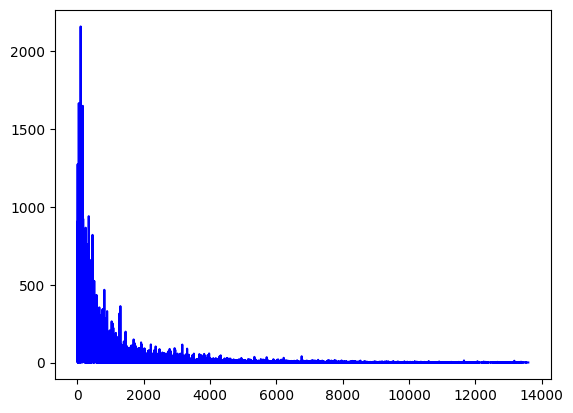

In [27]:
# Veamos la gráfica de palabras nuestro diccionario en orden de mayor frecuencia:

plt.plot(list(np.arange(len(mivocabulario))), list(mivocabulario.values()), color='blue')
plt.show()

###**Descartemos palabras cuya frecuencia en el conjunto de entrenamiento es muy pequeña:**

In [28]:
min_freq = 30
tmp = [{k:c} for k,c in mivocabulario.items() if c >= min_freq]

mivocabulario2 = {}
for i in range(len(tmp)):
  mivocabulario2.update(tmp[i])

print(len(mivocabulario2))  # reducimos el tamaño del vocabulario....
print(1-len(mivocabulario2)/len(mivocabulario))   # porcentaje de reducción...

962
0.9292334853611888


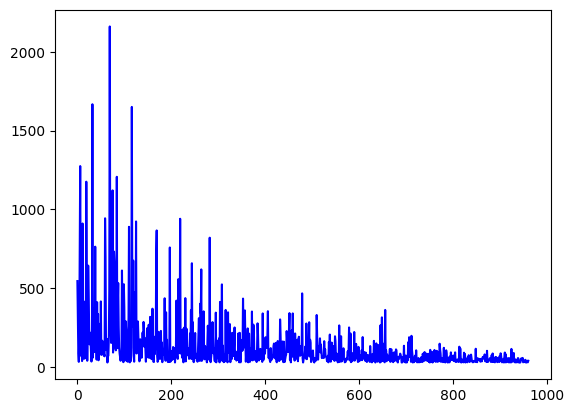

In [29]:
plt.plot(list(np.arange(len(mivocabulario2))), list(mivocabulario2.values()), color='blue')
plt.show()

In [30]:
total_words = len(mivocabulario2)

###**Filtremos los conjuntos Train, Validation y Test con respecto al nuestro vocabulario de palabras:**

In [31]:
train_x = []

for ss in x_train:
  train_x.append([w for w in ss if w in mivocabulario2])

In [32]:
for k in range(3):
  print(x_train[k])
  print(train_x[k])

['stroller', 'year', 'half', 'previously', 'chicco', 'cortina', 'stroller', 'loved', 'also', 'great', 'talls', 'im', 'feet', 'heavy', 'became', 'impractical', 'love', 'heavenly', 'stroller', 'umbrellatype', 'stroller', 'tall', 'enough', 'folds', 'easily', 'light', 'live', 'new', 'york', 'city', 'use', 'stroller', 'daughter', 'constantly', 'since', 'dont', 'car', 'daughter', 'tall', 'seems', 'perfectly', 'comfortable', 'itbut', 'weeks', 'ago', 'returning', 'home', 'park', 'one', 'handles', 'snapped', 'joint', 'unfixable', 'bummed', 'wasnt', 'buy', 'new', 'stroller', 'pretty', 'unusable', 'one', 'handle', 'one', 'feeling', 'really', 'wobbly', 'emailed', 'company', 'found', 'sent', 'two', 'replacement', 'handles', 'rolling', 'againi', 'think', 'handles', 'wore', 'use', 'stroller', 'multiple', 'times', 'day', 'long', 'short', 'distances', 'stairs', 'maneuvering', 'around', 'city', 'trains', 'shopping', 'etc', 'stroller', 'gets', 'heavy', 'wear', 'tear', 'everything', 'else', 'held', 'wheel

In [33]:
validation_x = []

for ss in x_validation:
  validation_x.append([w for w in ss if w in mivocabulario2])

In [34]:
for k in range(3):
  print(x_validation[k])
  print(validation_x[k])

['adorable', 'way', 'big', 'layette', 'others', 'said', 'returned', 'cannot', 'tell', 'age', 'actually', 'fit']
['adorable', 'way', 'big', 'others', 'said', 'returned', 'cannot', 'tell', 'age', 'actually', 'fit']
['absolutely', 'love', 'crib', 'set', 'spent', 'forever', 'researching', 'reviewing', 'peoples', 'opinions', 'different', 'kind', 'crib', 'sets', 'bit', 'hesitant', 'first', 'soon', 'got', 'mail', 'opened', 'fell', 'love', 'great', 'price', 'piece', 'set', 'completely', 'well', 'worth', 'moneyupdate', 'ended', 'not', 'using', 'long', 'looks', 'ended', 'wash', 'blanket', 'looks', 'real', 'used', 'pregnant', 'wont', 'wasting', 'money', 'crib', 'bedding', 'set', 'babies', 'dont', 'need', 'pillows', 'comforters', 'thing', 'uses', 'sheet', 'cute', 'first', 'get', 'magic', 'slowly', 'fades', 'away']
['absolutely', 'love', 'crib', 'set', 'spent', 'different', 'kind', 'crib', 'sets', 'bit', 'first', 'soon', 'got', 'opened', 'fell', 'love', 'great', 'price', 'piece', 'set', 'completely

In [35]:
test_x = []

for ss in x_test:
  test_x.append([w for w in ss if w in mivocabulario2])

In [36]:
for k in range(3):
  print(x_test[k])
  print(test_x[k])

['bought', 'son', 'last', 'december', 'great', 'car', 'seat', 'easy', 'use', 'install', 'love', 'point', 'harness', 'although', 'son', 'soon', 'outgrow', 'need', 'seat', 'comfy', 'never', 'complains', 'much', 'better', 'padded', 'comfortable', 'graco', 'booster', 'seats', 'opinion', 'think', 'probably', 'best', 'booster', 'seat', 'market', 'safety', 'wise', 'side', 'impact', 'protection', 'seems', 'excellent', 'large', 'sides', 'support', 'sons', 'head', 'well', 'naps', 'car', 'wish', 'would', 'fold', 'easier', 'transport', 'trunk', 'not', 'use', 'need', 'take', 'plane']
['bought', 'son', 'last', 'great', 'car', 'seat', 'easy', 'use', 'install', 'love', 'point', 'harness', 'although', 'son', 'soon', 'need', 'seat', 'comfy', 'never', 'much', 'better', 'padded', 'comfortable', 'graco', 'booster', 'seats', 'think', 'probably', 'best', 'booster', 'seat', 'safety', 'side', 'seems', 'excellent', 'large', 'sides', 'support', 'sons', 'head', 'well', 'car', 'wish', 'would', 'fold', 'easier', 'n

In [37]:
len(test_x)

500

###**matrices Tf-idf**

### Para obtener las matrices sparse debe estar de nuevo cada comentario/documento en un solo string:



In [38]:
train_x_docs = []

for k in range(len(train_x)):
  train_x_docs.append(' '.join(train_x[k]))

In [39]:
for k in range(3):
  print(train_x_docs[k])

stroller year half chicco stroller loved also great im feet heavy became love stroller stroller tall enough folds easily light live new use stroller daughter constantly since dont car daughter tall seems perfectly comfortable weeks ago returning home one handles wasnt buy new stroller pretty one handle one really company found sent two replacement handles think handles use stroller multiple times day long short around shopping etc stroller gets heavy wear everything else held wheels little no problems must say im impressed customer service wasnt great highly recommend stroller
not even sure safe kids sleep like putting putting bed time son getting sleep one decided order high would help didnt first able pull legs onto body gets stuck like position put keep room cool still way thick really hoping would help us sleep didnt
tried ring thats loose dont money right get sized not skin fell lost wouldnt recommend


In [40]:
validation_x_docs = []

for k in range(len(validation_x)):
  validation_x_docs.append(' '.join(validation_x[k]))

In [41]:
test_x_docs = []

for k in range(len(test_x)):
  test_x_docs.append(' '.join(test_x[k]))

In [42]:
len(test_x_docs)

500

###**TOKENIZER**

Con Tf-Idf se hace la conversión de letras a números con la fórmula de de tf-idf y los agrupa de manera descendente por frecuencias.


In [43]:
# Creamos el tokenizer
tokenizer = Tokenizer(num_words = total_words)

tokenizer.fit_on_texts(train_x_docs)

train_sequences = tokenizer.texts_to_sequences(train_x_docs)

validation_sequences = tokenizer.texts_to_sequences(validation_x_docs)

test_sequences = tokenizer.texts_to_sequences(test_x_docs)

In [44]:
tokenizer.num_words  # tamaño del vocabulario

962

In [45]:
#tokenizer.index_word   # tokens indexados por frecuencia, de manera descendente.

In [46]:
tokenizer.index_word[3]  # puedes obtener cualquier token en particular

'baby'

In [47]:
tokenizer.word_index['baby']   # y obtener el índice del token de esta manera.

3

In [48]:
print("The document and its encoding:\n",train_x_docs[0], '\n', train_sequences[0])

The document and its encoding:
 stroller year half chicco stroller loved also great im feet heavy became love stroller stroller tall enough folds easily light live new use stroller daughter constantly since dont car daughter tall seems perfectly comfortable weeks ago returning home one handles wasnt buy new stroller pretty one handle one really company found sent two replacement handles think handles use stroller multiple times day long short around shopping etc stroller gets heavy wear everything else held wheels little no problems must say im impressed customer service wasnt great highly recommend stroller 
 [30, 79, 368, 841, 30, 138, 15, 4, 39, 445, 300, 769, 11, 30, 30, 504, 44, 594, 75, 149, 561, 74, 6, 30, 28, 746, 51, 24, 35, 28, 504, 104, 206, 126, 170, 339, 809, 237, 2, 524, 210, 52, 74, 30, 95, 2, 327, 2, 16, 328, 127, 646, 47, 452, 524, 69, 524, 6, 30, 703, 174, 109, 88, 358, 45, 414, 346, 30, 176, 300, 397, 193, 430, 403, 472, 8, 20, 286, 272, 164, 39, 936, 446, 439, 210, 

In [49]:
len(train_sequences)  # siguen siendo el mismo nuumero de renglones inicial de los de entrenamiento.

4000

In [50]:
# Add padding, "post" or "pre":
# maxlen es la longitud máxima permitida de un enunciado. Puedes calcular el documento de mayor longitud y tomar ese,
# o bien, tomar un aproximado... en este caso tomamos 40, más allá de esto, se trunca.

padded_train = pad_sequences(train_sequences, maxlen = 40, padding = 'post', truncating = 'post')

padded_validation = pad_sequences(validation_sequences, maxlen = 40, padding = 'post', truncating = 'post')

padded_test = pad_sequences(test_sequences, maxlen = 40,  padding = 'post', truncating = 'post')

In [51]:
for i,doc in enumerate(padded_train[:3]):
     print("La codificación del documento",i+1,"es:\n",doc)

La codificación del documento 1 es:
 [ 30  79 368 841  30 138  15   4  39 445 300 769  11  30  30 504  44 594
  75 149 561  74   6  30  28 746  51  24  35  28 504 104 206 126 170 339
 809 237   2 524]
La codificación del documento 2 es:
 [  1  27 103 195 119 122   7 347 347 144  18  22 116 122   2 257 294 157
   5 258  49  31  96 245 371 514 747 176 492   7 387  26  70  54 883  32
  50 547  16 704]
La codificación del documento 3 es:
 [120 748 261 819  24 145  76  12 884   1 907 705 759 256  36   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0]


In [52]:
print(padded_train.shape)
print(padded_test.shape)

(4000, 40)
(500, 40)


In [53]:
y_train_arr = np.asarray(y_train)    # de Series --> array
y_validation_arr = np.asarray(y_validation)
y_test_arr = np.asarray(y_test)

In [54]:
# veamos qué tan bien quedaron repartidas las clases en cada conjunto:
print('Conjunto inicial:', sum(Y)/len(Y))

print('Conjunto de entrenamiento:', sum(y_train)/len(y_train))
print('Conjunto de valicación:',  sum(y_validation)/len(y_validation))
print('Conjunto de prueba:', sum(y_test)/len(y_test))

Conjunto inicial: 0.768
Conjunto de entrenamiento: 0.771
Conjunto de valicación: 0.79
Conjunto de prueba: 0.722


# **La Tarea consiste en encontrar la arquitectura que nos genere un modelo que no esté subentrenado o sobreentrenado.**

# **Diremos que el modelo no está sobreentrenado si la diferencia entre el accuracy del conjunto de Entrenamiento y el de Validación es menor al 3%.**

In [66]:
model = Sequential()

# embeddidng layer:
model.add(Embedding(input_dim=total_words, output_dim = 8, embeddings_initializer='uniform'))    # 256
model.add(LSTM(8, return_sequences=True))
model.add(Dropout(0.40))


'''
model.add(LSTM(256, return_sequences=True))
#model.add(Dropout(0.3))   # si deseas agregar DropOut

model.add(LSTM(128, return_sequences=True))
model.add(Dropout(None))

model.add(LSTM(128, return_sequences=True))
model.add(Dropout(None))

model.add(LSTM(64, return_sequences=True))
model.add(Dropout(None))
'''
model.add(LSTM(12))



# Dense layers
model.add(Dense(32, activation = 'relu'))
#model.add(Dropout(None))

model.add(Dense(1,activation= 'sigmoid'))


model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 8)           7696      
                                                                 
 lstm_4 (LSTM)               (None, None, 8)           544       
                                                                 
 dropout_2 (Dropout)         (None, None, 8)           0         
                                                                 
 lstm_5 (LSTM)               (None, 12)                1008      
                                                                 
 dense_4 (Dense)             (None, 32)                416       
                                                                 
 dense_5 (Dense)             (None, 1)                 33        
                                                                 
Total params: 9697 (37.88 KB)
Trainable params: 9697 (

In [67]:
n_epochs = 4     # número de épocas
n_batch = 84 # 128   # tamaño de bloques de entrenamiento

H = model.fit(padded_train, y_train_arr, batch_size = n_batch, validation_data=(padded_validation, y_validation_arr), epochs = n_epochs)

Epoch 1/4
48/48 [==============================] - 12s 158ms/step - loss: 0.5987 - acc: 0.7648 - val_loss: 0.5121 - val_acc: 0.7900
Epoch 2/4
48/48 [==============================] - 3s 68ms/step - loss: 0.5238 - acc: 0.7710 - val_loss: 0.4920 - val_acc: 0.7900
Epoch 3/4
48/48 [==============================] - 2s 51ms/step - loss: 0.4276 - acc: 0.8167 - val_loss: 0.3427 - val_acc: 0.8580
Epoch 4/4
48/48 [==============================] - 1s 28ms/step - loss: 0.3179 - acc: 0.8725 - val_loss: 0.3435 - val_acc: 0.8540


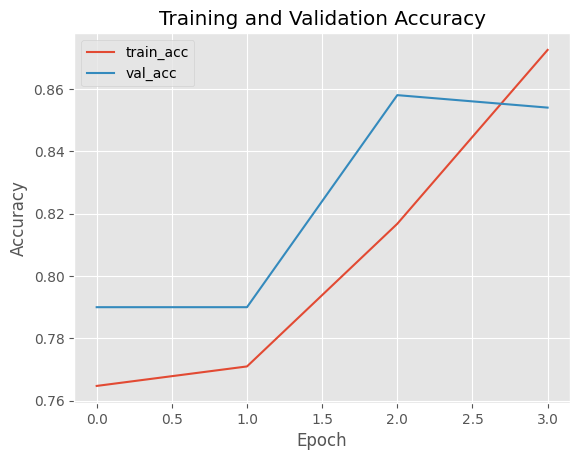

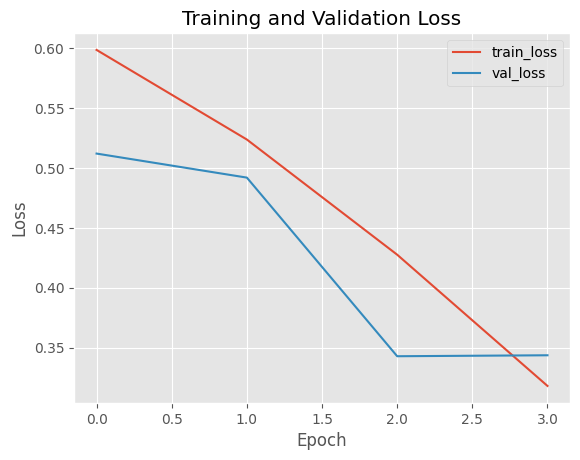

In [68]:
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0,n_epochs),H.history["acc"],label="train_acc")
plt.plot(np.arange(0,n_epochs),H.history["val_acc"],label="val_acc")
plt.title("Training and Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.figure()
plt.plot(np.arange(0,n_epochs),H.history["loss"],label="train_loss")
plt.plot(np.arange(0,n_epochs),H.history["val_loss"],label="val_loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()

In [69]:
# make prediction
pred = model.predict(padded_test)

16/16 [==============================] - 1s 4ms/step


In [70]:
padded_test.shape

(500, 40)

In [71]:
# if the predicted value is >0.5 it is real else it is fake
prediction = []
for i in range(len(pred)):
    if pred[i].item() > 0.5:  # podemos buscar el mejor umbral...
        prediction.append(1)
    else:
        prediction.append(0)

In [72]:
# getting the accuracy
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(list(y_test_arr), prediction)

print("Model Accuracy : ", accuracy)

Model Accuracy :  0.802


In [73]:
# se puede calcular de manera más sencilla, pero por default el umbral es 0.5
predic = np.round(pred)
accuracy_score(list(y_test_arr), predic)

0.802

In [74]:
# get the confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(list(y_test_arr), prediction)
print(cm)


[[ 62  77]
 [ 22 339]]


Bajamos considerablemente las capas predeterminadas en el ejercicio a **8 LSTM**, esto debido a que el data set no requiere de tanto nivel de procesamiento. Entendiendo que una capa LSTM más pequeña tiene menos parámetros y, por lo tanto, es menos probable que aprenda patrones específicos del conjunto de entrenamiento y por lo tanto simplificar su procesamiento y entendimiento.

Adicional, decidimos agregar el valor de **Dropout** sabiendo que esto nos podría ayudar a regularizar y prevenir el sobreajuste del modelo. Este ajuste ayuda a que el modelo no dependa excesivamente de ninguna neurona específica o combinación de neuronas para hacer predicciones, obligando a que la red neuronal aprenda características más robustas y generalizables de los datos, lo que a su vez ayuda a prevenir el sobreajuste. **Probamos varios valores, siendo el de 0.40 el que nos devolvió 3 veces una diferencia de precisión entre set de entrenamiento y validación,menor de 3% con una precisión del modelo de 80.2%** con el set de entrenamiento.

Otro cambio que probamos fue el # de épocas y tamaño de los batchs, viendo que obtuvimos mejores resultados los cuando disminuimos a **4 épocas, con tamaño de lotes de 84**. Lo cual nos dice que para ese set de datos con 6 transiciones entre las neuornas son suficientes para que el modelo no haga sobreajustes.

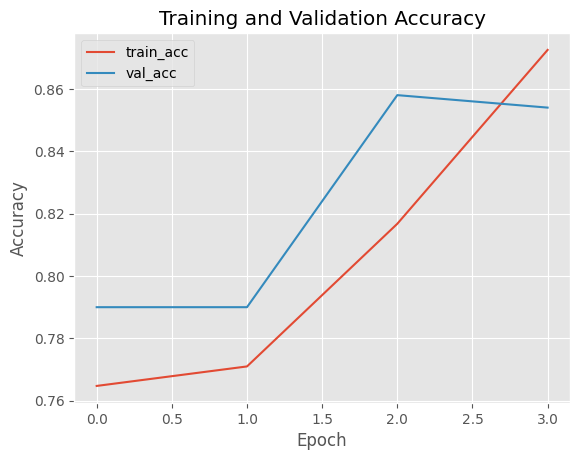